<a href="https://colab.research.google.com/github/Priyansh012/CECS550-Facial-Expression-Recognition/blob/main/MobileNet_Based_Facial_Expression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960  # Size of chunks to read in bytes
DATA_SOURCE_MAPPING = 'fer13-cleaned-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F610656%2F1093138%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240515%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240515T014924Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D020317df4c95d6995189a046bb171810e48b9182a8c45efcffa1feec7bbcdc20dd42fa59ddd0ba79cb1382baeea3673e060f0211698bc0c4864d8c0a9d7a7bf8e5f8546dd73983491b452c79898aae9fe3cf8fdd87a6dfe5183505e8fc72be552177f829e73032d6895703f3cde21aa20c152378232679b452a6444666a7676666357948906c87c70f8b8fb2690930ac99f3609743ffba00496c2b311a42f55c554cb3eba04b26a5fa18d8cc1ba9965c6fc3bcaf5b53bd4eb3ede4b49968d00b0f5c25c1f622f3747b36457d329ec366e8cc29de8d4efae0fca20230e5b9f6640303ddf30f7d8aa8416d03665504332a50053b418a3a4c63e4a989ec291f9897'

KAGGLE_INPUT_PATH = '/kaggle/input'
KAGGLE_WORKING_PATH = '/kaggle/working'
KAGGLE_SYMLINK = 'kaggle'

# Unmount and remove /kaggle/input if it exists
!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)

# Create necessary directories
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

# Create symlinks for input and working directories
try:
    os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
    pass
try:
    os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
    pass

# Iterate over each data source mapping
for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)

    try:
        # Open the download URL and create a temporary file
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)

            # Read data in chunks and write to the temporary file
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)

            # Extract the file based on its type
            if filename.endswith('.zip'):
                with ZipFile(tfile) as zfile:
                    zfile.extractall(destination_path)
            else:
                with tarfile.open(tfile.name) as tarfile:
                    tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')

    # Handle errors during download
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 29612610 bytes downloaded
Downloaded and uncompressed: fer13-cleaned-dataset
Data source import complete.


In [ ]:
pip install scikit-plot

In [ ]:
import os
import cv2
import math
import numpy as np
import pandas as pd
import scikitplot

# Visualization libraries
import seaborn as sns
from matplotlib import pyplot

# Machine learning utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Deep learning framework
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, GlobalAvgPool2D, GlobalMaxPool2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.utils import plot_model,to_categorical

In [ ]:
data_path = "../input/fer13-cleaned-dataset/"


In [ ]:
# Count the number of images in each directory and the total number of images
total_images_count = 0
for directory in os.listdir(data_path):
    count = 0
    for file in os.listdir(data_path + directory + "/"):
        count += 1
        total_images_count += 1
    print(f"{directory} has {count} number of images")

print(f"\ntotal images are {total_images_count}")


Happy has 6834 number of images
fear has 2535 number of images
disgust has 380 number of images
Neutral has 4295 number of images
Angry has 2832 number of images

total images are 16876


In [ ]:
# Adjust total image count by subtracting 380
selected_emotions = ["fear", "Happy", "Neutral", "Angry"]
total_images_count -= 380
total_images_count


16496

In [ ]:
import numpy as np

# Create empty arrays to store images and labels
image_array = np.empty(shape=(total_images_count, 48, 48, 3))
image_labels = np.empty(shape=(total_images_count))
label_to_text = {}

index = 0
emotion_index = 0

# Loop through each directory to load images and assign labels
for directory in os.listdir(data_path):
    if directory in selected_emotions:
        label_to_text[emotion_index] = directory
        for file in os.listdir(data_path + directory + "/"):
            # Load image into numpy array and assign label
            image_array[index] = cv2.imread(data_path + directory + "/" + file)
            image_labels[index] = emotion_index
            index += 1
        print(f"Loaded all {directory} images to numpy arrays")
        emotion_index += 1

# Display shape of image array and labels array
image_array.shape, image_labels



Loaded all Happy images to numpy arrays
Loaded all fear images to numpy arrays
Loaded all Neutral images to numpy arrays
Loaded all Angry images to numpy arrays


((16496, 48, 48, 3), array([0., 0., 0., ..., 3., 3., 3.]))

In [ ]:
label_to_text

{0: 'Happy', 1: 'fear', 2: 'Neutral', 3: 'Angry'}

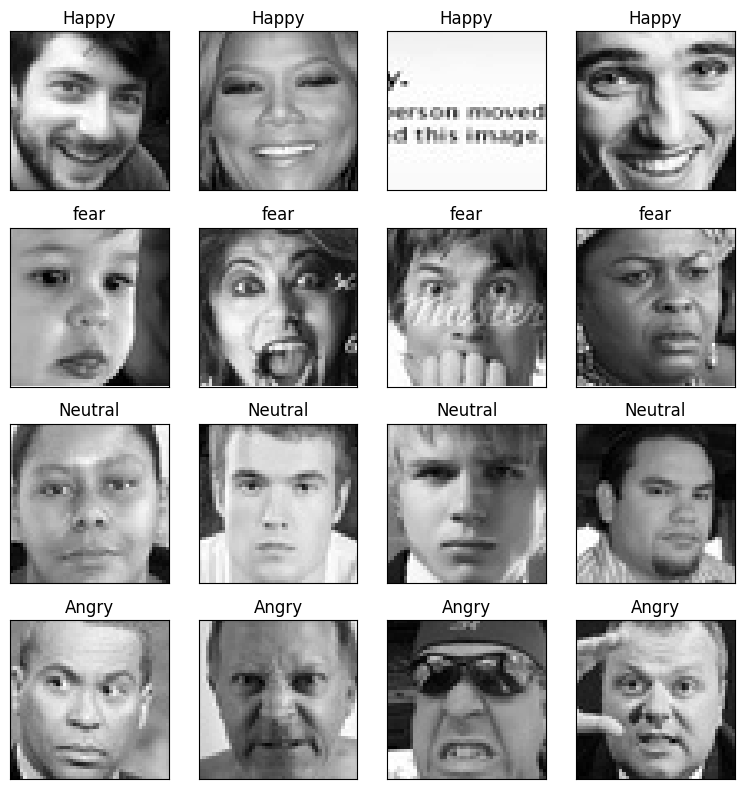

In [ ]:
import matplotlib.pyplot as plt

# Create a figure for displaying sample images
fig = plt.figure(1, (8, 8))

index = 0
# Iterate over each emotion category
for emotion_index in label_to_text:
    # Randomly select 4 sample indices for the current emotion category
    sample_indices = np.random.choice(np.where(image_labels == emotion_index)[0], size=4, replace=False)
    sample_images = image_array[sample_indices]
    # Plot each sample image
    for image in sample_images:
        index += 1
        subplot = plt.subplot(4, 4, index)
        subplot.imshow(image[:, :, 0], cmap='gray')  # Display grayscale image
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.set_title(label_to_text[emotion_index])
        plt.tight_layout()



In [ ]:
from tensorflow.keras.utils import to_categorical

image_labels = to_categorical(image_labels)
image_labels.shape


(16496, 4)

`Splitting the data into training and validation set.`

In [ ]:
image_array = image_array / 255


In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(image_array, image_labels,
                                                    shuffle=True, stratify=image_labels,
                                                    train_size=0.9, random_state=42)

# Display the shapes of the training and testing sets
x_train.shape, x_test.shape, y_train.shape, y_test.shape


((14846, 48, 48, 3), (1650, 48, 48, 3), (14846, 4), (1650, 4))

In [ ]:
del image_array
del image_labels


In [ ]:
img_width = x_train.shape[1]
img_height = x_train.shape[2]
img_depth = x_train.shape[3]
num_categories = y_train.shape[1]


In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense
from tensorflow.keras.models import Model

# Create MobileNet model with pre-trained weights
mobile_net_model = MobileNet(
    input_shape=(img_width, img_height, img_depth),
    include_top=False,
    weights="imagenet",
    classes=num_categories
)

# Extract output of the 14th layer from the end of MobileNet
x = mobile_net_model.layers[-14].output
global_pool = GlobalMaxPooling2D(name="global_pool")(x)
output_layer = Dense(num_categories, activation="softmax", name="out_layer")(global_pool)

# Define the final model
model = Model(inputs=mobile_net_model.input, outputs=output_layer)


17225924/17225924 [==============================] - 0s 0us/step


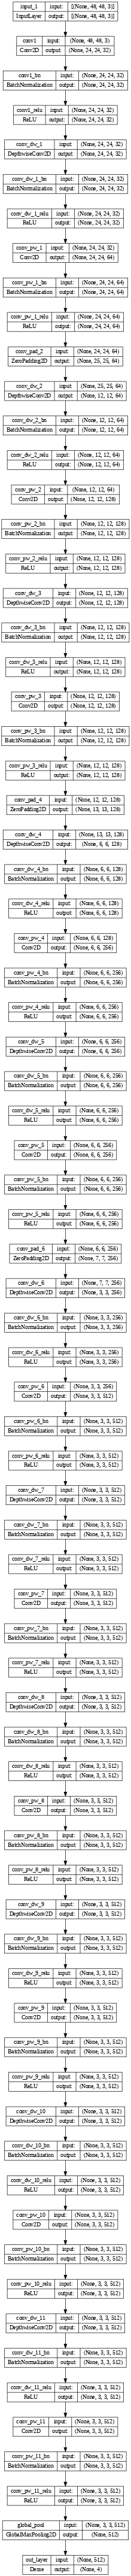

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50, to_file='mobilenet.png')


In [ ]:
for some_layer in model.layers[:15]:
    some_layer.trainable = False


In [ ]:
# Define the data augmentation parameters for the training data generator
train_data_generator = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    zca_whitening=False,
)
# Fit the data generator to the training data
train_data_generator.fit(x_train)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define early stopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00008,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

# Define learning rate scheduler callback
lr_scheduler_callback = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.25,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)

# Create list of callbacks
callbacks_list = [
    early_stopping_callback,
    lr_scheduler_callback,
]



In [ ]:
# Define batch size and number of epochs
batch_size = 25
epochs = 40

# List of optimizers
optimizers_list = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    optimizers.Adam(0.01),
]

# Compile the model with chosen optimizer and evaluation metrics
model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizers_list[1],
        metrics=['accuracy']
)

# Train the model using fit_generator method
history = model.fit_generator(
    train_data_generator.flow(x_train, y_train, batch_size=batch_size),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks_list,
    use_multiprocessing=True
)


<ipython-input-21-193222fd7e39>:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/40


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


592/593 [============================>.] - ETA: 0s - loss: 1.3205 - accuracy: 0.4994

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


593/593 [==============================] - 49s 62ms/step - loss: 1.3203 - accuracy: 0.4991 - val_loss: 1.0492 - val_accuracy: 0.6067 - lr: 0.0100
Epoch 2/40
593/593 [==============================] - 35s 59ms/step - loss: 0.9818 - accuracy: 0.6018 - val_loss: 0.9296 - val_accuracy: 0.6485 - lr: 0.0100
Epoch 3/40
593/593 [==============================] - 35s 59ms/step - loss: 0.9142 - accuracy: 0.6379 - val_loss: 1.1346 - val_accuracy: 0.5533 - lr: 0.0100
Epoch 4/40
593/593 [==============================] - 35s 59ms/step - loss: 0.8770 - accuracy: 0.6505 - val_loss: 0.7987 - val_accuracy: 0.6891 - lr: 0.0100
Epoch 5/40
593/593 [==============================] - 35s 59ms/step - loss: 0.8484 - accuracy: 0.6654 - val_loss: 0.8665 - val_accuracy: 0.6612 - lr: 0.0100
Epoch 6/40
593/593 [==============================] - 34s 57ms/step - loss: 0.8245 - accuracy: 0.6721 - val_loss: 0.8979 - val_accuracy: 0.6497 - lr: 0.0100
Epoch 7/40
593/593 [==============================] - 34s 58ms/step -

In [ ]:
# Serialize model to JSON
model_json = model.to_json()
with open("model_mobilenet.json", "w") as json_file:
    json_file.write(model_json)

# Save model weights to HDF5
model.save("model_mobilenet.h5")



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


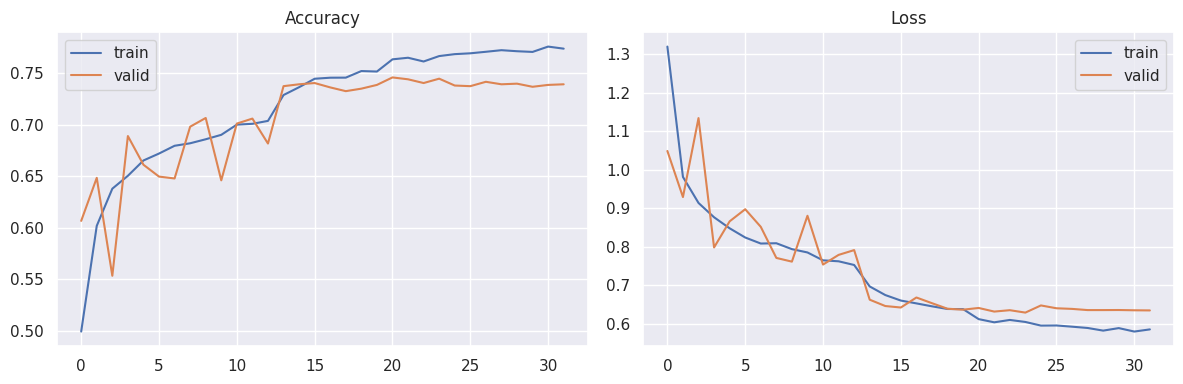

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

# Create a figure for plotting
fig = plt.figure(0, (12, 4))

# Plot accuracy
ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

# Plot loss
ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

# Display the plot
plt.savefig('epoch_history_mobilenet.png')
plt.show()



In [ ]:
label_to_text

{0: 'Happy', 1: 'fear', 2: 'Neutral', 3: 'Angry'}

In [ ]:
text_to_label = dict((v,k) for k,v in label_to_text.items())
text_to_label

{'Happy': 0, 'fear': 1, 'Neutral': 2, 'Angry': 3}

52/52 [==============================] - 3s 17ms/step
Test accuracy: 74.6061 %


              precision    recall  f1-score   support

           0       0.92      0.85      0.88       684
           1       0.68      0.46      0.55       253
           2       0.65      0.82      0.73       430
           3       0.60      0.64      0.62       283

    accuracy                           0.75      1650
   macro avg       0.71      0.69      0.69      1650
weighted avg       0.76      0.75      0.74      1650



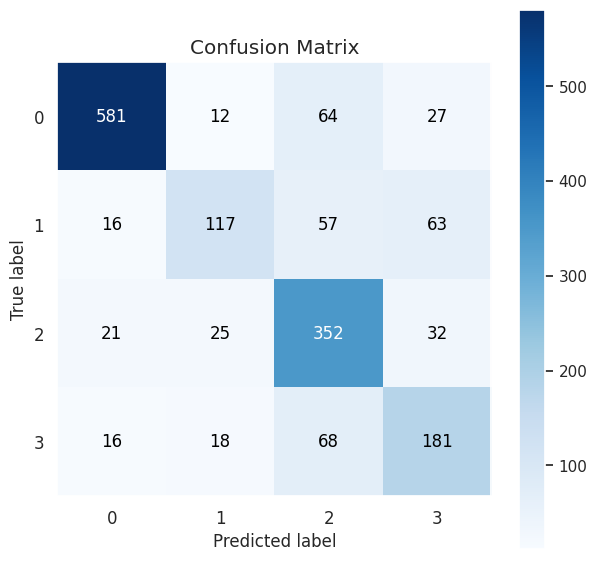

In [ ]:
from sklearn.metrics import classification_report
import scikitplot as skplt

# Predict classes for test set
y_pred_test = np.argmax(model.predict(x_test), axis=1)
y_true_test = np.argmax(y_test, axis=1)

# Plot confusion matrix
skplt.metrics.plot_confusion_matrix(y_true_test, y_pred_test, figsize=(7,7))
plt.savefig("confusion_matrix_mobilenet.png")

test_accuracy = np.sum(y_true_test == y_pred_test) / len(y_true_test) * 100
print(f"Test accuracy: {round(test_accuracy, 4)} %\n\n")

# Generate and print classification report
print(classification_report(y_true_test, y_pred_test))


The confusion matrix clearly shows that our model is doing good job on the class `happy` but it's performance is not that good on other classes. One of the reason for this could be the fact that these classes have less data as compared to `happy`.

1/1 [==============================] - 0s 29ms/step


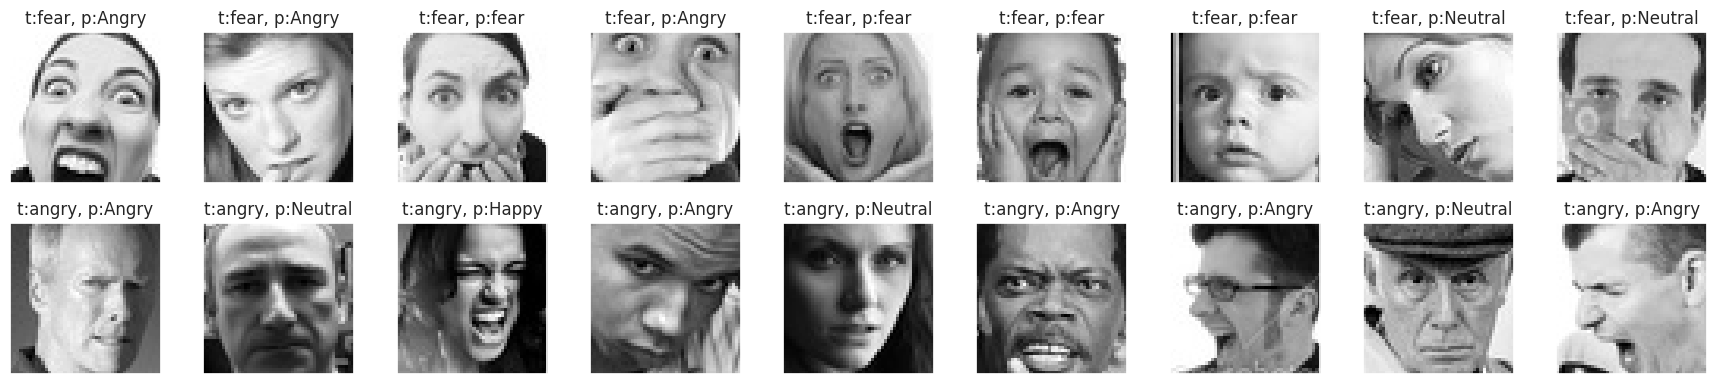

In [ ]:
np.random.seed(42)
fear_imgs = np.random.choice(np.where(y_test[:, text_to_label["fear"]]==1)[0], size=9, replace=False)
angry_imgs = np.random.choice(np.where(y_test[:, text_to_label["Angry"]]==1)[0], size=9, replace=False)

fig = pyplot.figure(1, (18, 4))

# Plot fear and angry images with their predicted labels
for i, (fear_idx, angry_idx) in enumerate(zip(fear_imgs, angry_imgs)):
        sample_img = x_test[fear_idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = pyplot.subplot(2, 9, i+1)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:fear, p:{pred}")

        sample_img = x_test[angry_idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = pyplot.subplot(2, 9, i+10)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:angry, p:{pred}")

        pyplot.tight_layout()

One of the reason for such low accuracy is the data quality. Below I have shown all the miss-classified images. Many of them doesn't belong to their true class but are actually looking more likely to the predicted class.

In [ ]:
import math

# Define a function to plot misclassified images for a given emotion
def plot_miss_classified(emotion):
    miss_indices = np.where((y_true_test != y_pred_test) & (y_true_test == text_to_label[emotion]))[0]
    print(f"Total {len(miss_indices)} misclassified labels out of {len(np.where(y_true_test == text_to_label[emotion])[0])} for emotion {emotion}")

    cols = 15
    rows = math.ceil(len(miss_indices) / cols)
    fig = plt.figure(1, (20, rows * 2))
    # Plot misclassified images
    for i, idx in enumerate(miss_indices):
        sample_img = x_test[idx,:,:,:]
        sample_img = sample_img.reshape(1, *sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"p:{pred}")


Total 103 misclassified labels out of 684 for emotion Happy
1/1 [==============================] - 0s 18ms/step


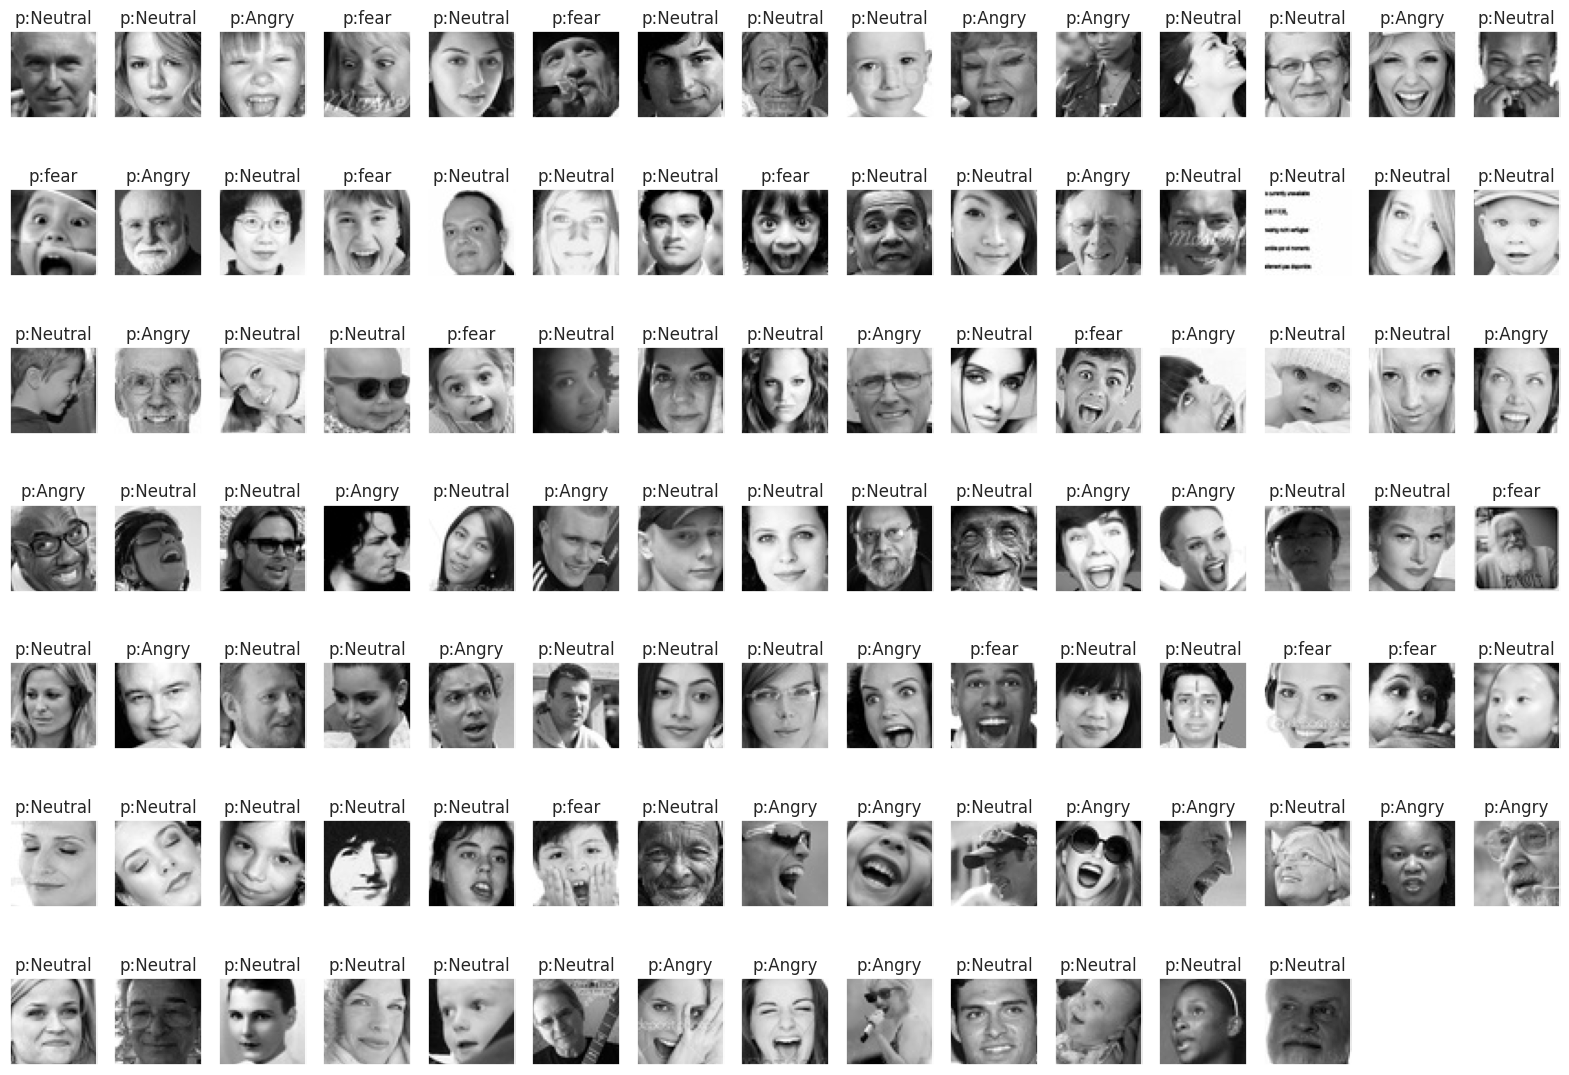

In [ ]:
plot_miss_classified(emotion="Happy")

As we see most of these are classified as `fear` the reason for that is that most of the fear mouths are opened as we see earlier and many of these mouths are opened like that.

Total 136 misclassified labels out of 253 for emotion fear
1/1 [==============================] - 0s 32ms/step


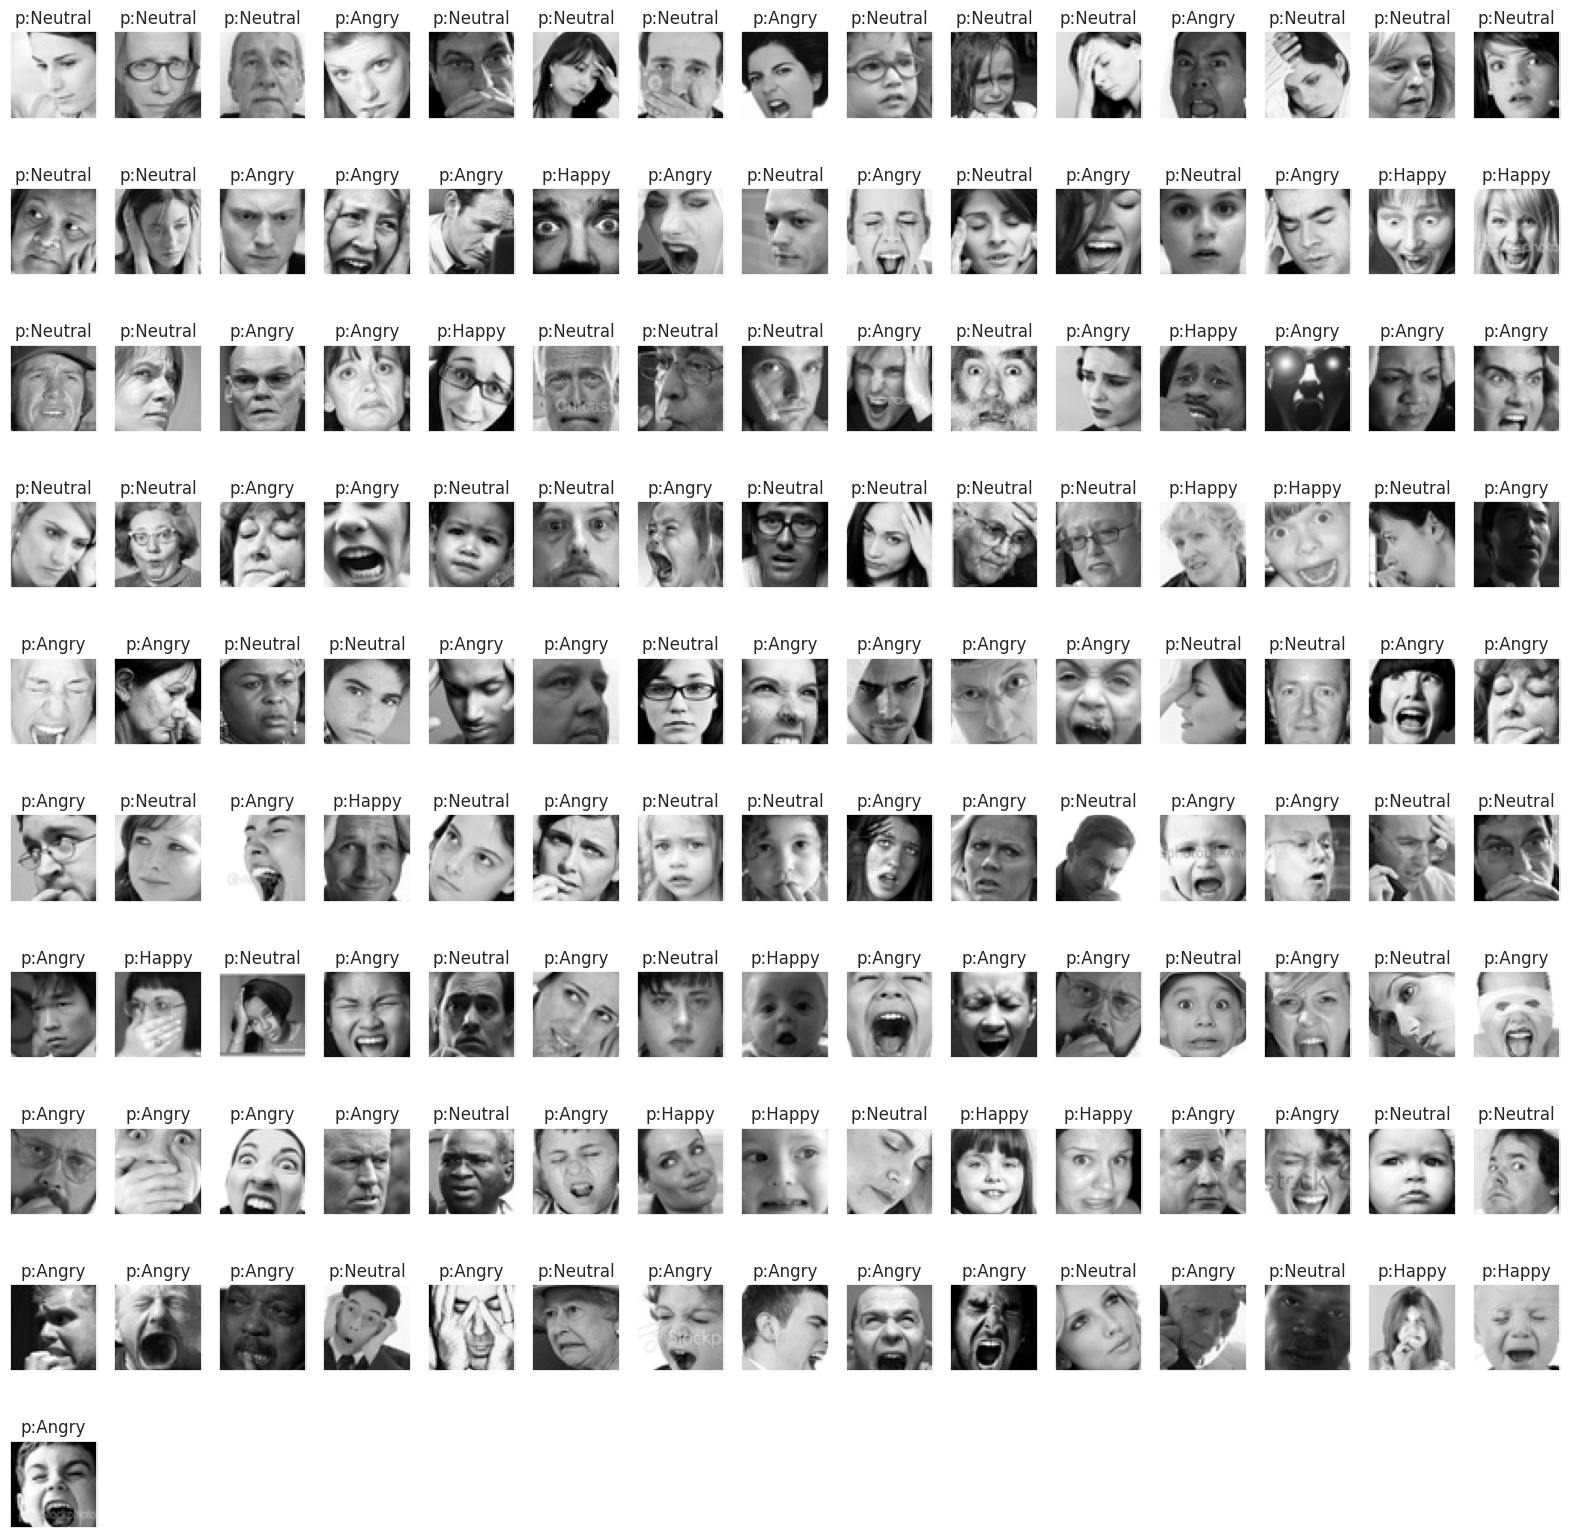

In [ ]:
plot_miss_classified(emotion="fear")

Total 102 misclassified labels out of 283 for emotion Angry
1/1 [==============================] - 0s 19ms/step


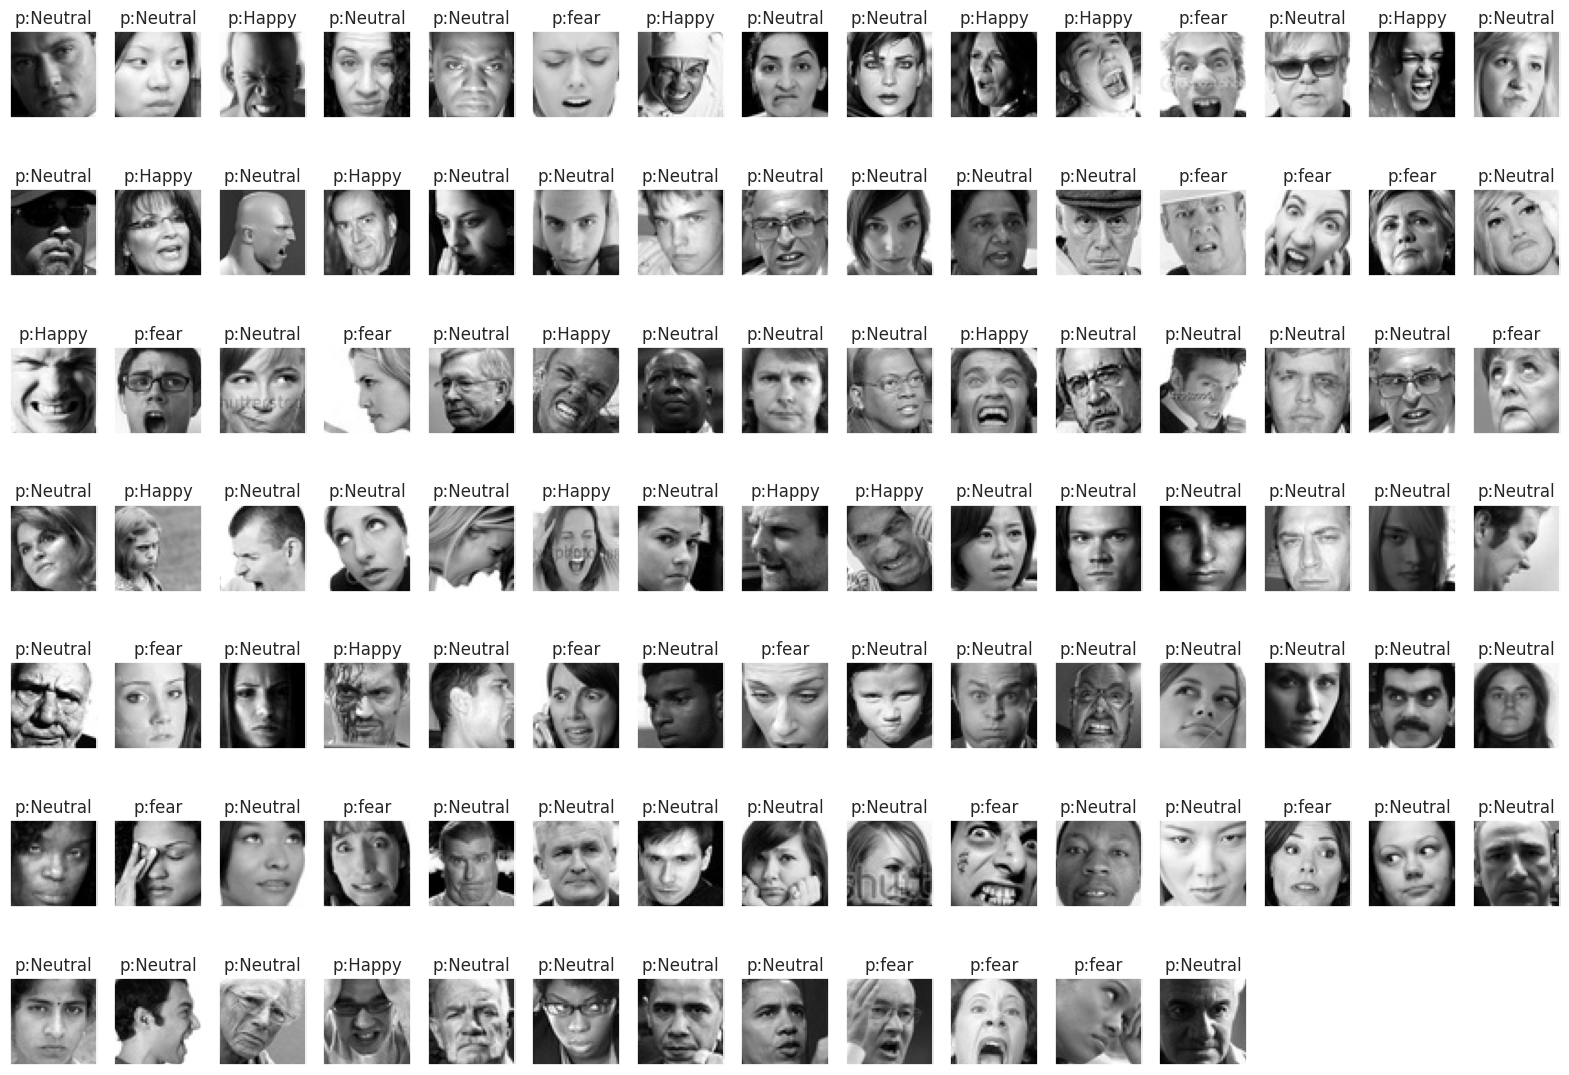

In [ ]:
plot_miss_classified(emotion="Angry")

total 96 miss labels out of 430 for emotion Neutral
1/1 [==============================] - 0s 18ms/step


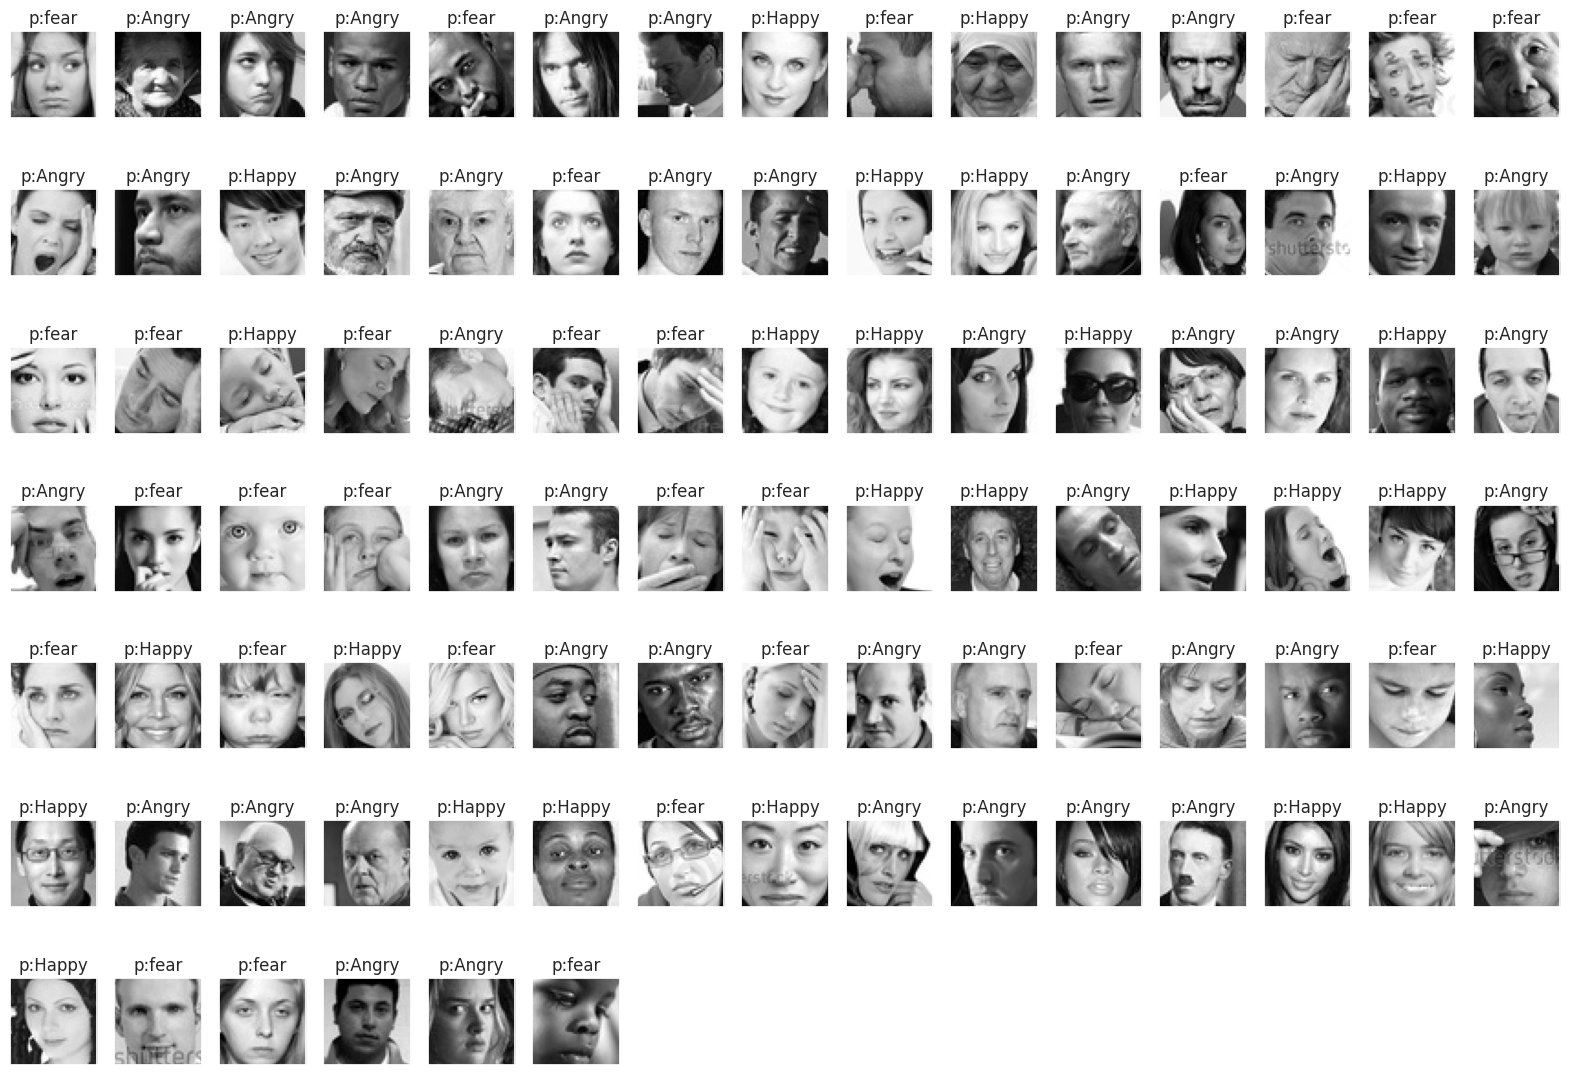

In [ ]:
plot_miss_classified(emotion="Neutral")